### uci 신용카드 자료 분석
- PCA로 불필요한 컬럼 제거 연습

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16
from keras.utils import plot_model # 모델 플롯 그리기
from keras.utils import set_random_seed # 랜덤 시드 설정
from keras.models import save_model, load_model # 모델 저장 및 로드
from sklearn.decomposition import PCA, NMF

In [3]:
df = pd.read_excel("default of credit card clients.xls", skiprows=1, index_col=0)
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

In [5]:
data = df.iloc[:,:23]
target = df.iloc[:,23]

### 표준화 작업

In [6]:
st = StandardScaler()
st.fit(data)
data = st.transform(data)

### PCA
- n_components=0.95일때, 23개의 컬럼 -> 15개의 컬럼 감소

In [7]:
pca = PCA(n_components=0.95)
pca.fit(data)
data_pca = pca.transform(data)

In [43]:
sl = []
for i in np.arange(0.6, 1, 0.05):
    pca = PCA(n_components=i)
    pca.fit(data)
    sl.append(pca.transform(data).shape[1])
print(sl)

[5, 6, 7, 8, 10, 11, 13, 15]


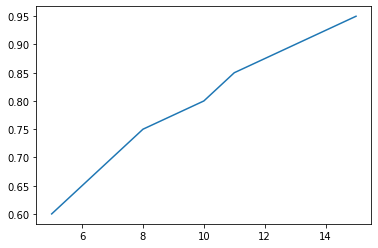

In [44]:
plt.plot(sl, np.arange(0.6,1,0.05))
plt.show()

In [8]:
train_data, test_data, train_target, test_target = train_test_split(data_pca, target, test_size=0.2, stratify=target, random_state=42)
train_data2, val_data, train_target2, val_target = train_test_split(train_data, train_target,test_size=0.2, stratify=train_target, random_state=42 )

In [9]:
print(train_data2.shape)

(19200, 15)


In [10]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_data2, train_target2)
print(lr.score(train_data2,train_target2 ))
print(lr.score(test_data,test_target ))

0.8117708333333333
0.807


In [21]:
md = Sequential()
md.add(Dense(16, activation='selu', input_shape=(15,) ))
md.add(Dense(8, activation='selu' ))
md.add(Dense(4, activation='selu' ))
md.add(Dense(2, activation='softmax'))
md.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics='accuracy')
es = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=8)
history = md.fit(train_data2, train_target2, validation_data=(val_data, val_target), epochs=50, callbacks=[es])


Epoch 1/50
600/600 [==============================] - 2s 2ms/step - loss: 0.4880 - accuracy: 0.7920 - val_loss: 0.4739 - val_accuracy: 0.8046
Epoch 2/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4543 - accuracy: 0.8097 - val_loss: 0.4681 - val_accuracy: 0.8104
Epoch 3/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4496 - accuracy: 0.8117 - val_loss: 0.4631 - val_accuracy: 0.8092
Epoch 4/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4470 - accuracy: 0.8129 - val_loss: 0.4600 - val_accuracy: 0.8098
Epoch 5/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4445 - accuracy: 0.8147 - val_loss: 0.4604 - val_accuracy: 0.8094
Epoch 6/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4431 - accuracy: 0.8148 - val_loss: 0.4573 - val_accuracy: 0.8100
Epoch 7/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4419 - accuracy: 0.8155 - val_loss: 0.4552 - val_accuracy: 0.8094
Epoch 

### GridSearchCV 이용

In [24]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
def get_model(neuron_1, neuron_2,neuron_3,drop_rate, learning_rate, input_shape=(15,)):
    # note that meta is a special argument that will be
    # handed a dict containing input metadata
    model = Sequential()
    model.add(Dense(neuron_1, activation='relu', input_shape=input_shape))
    model.add(Dropout(drop_rate))
    model.add(Dense(neuron_2, activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(neuron_3, activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(3, activation='softmax'))
    return model
clf = KerasClassifier(get_model,neuron_1=16, neuron_2=16,neuron_3=16, learning_rate=0.001, drop_rate=0.3, epochs=50, loss='sparse_categorical_crossentropy')

In [26]:
params = {
    "loss": ["sparse_categorical_crossentropy"],
    "optimizer": ["adam", "sgd"],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1],
    "neuron_1": [16,24,32,40,48,56,64],
    "neuron_2": [16,24,32,40,48,56,64],
    "neuron_3": [16,24,32,40,48,56,64],
    "drop_rate":[0.3,0.4,0.5,0.6,0.7]
}
rs = RandomizedSearchCV(clf, params, cv=3, scoring='accuracy', refit=True, return_train_score=True, n_jobs=-1, verbose=0)

rs.fit(train_data2, train_target2)
print(rs.best_score_, rs.best_params_)


Epoch 1/50
600/600 [==============================] - 2s 2ms/step - loss: 0.5302
Epoch 2/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4736
Epoch 3/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4614
Epoch 4/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4571
Epoch 5/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4519
Epoch 6/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4496
Epoch 7/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4469
Epoch 8/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4438
Epoch 9/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4411
Epoch 10/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4408
Epoch 11/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4397
Epoch 12/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4420
Epoch 13/50
600/600 [====

In [27]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
def get_model(hidden_n,neuron_n,drop_rate, learning_rate, input_shape=(15,)):
    # note that meta is a special argument that will be
    # handed a dict containing input metadata
    model = Sequential()
    model.add(Dense(neuron_n, activation='relu', input_shape=input_shape))
    model.add(Dropout(drop_rate))
    for i in range(hidden_n):
        model.add(Dense(neuron_n, activation='relu'))
        model.add(Dropout(drop_rate))
    model.add(Dense(3, activation='softmax'))
    return model
clf = KerasClassifier(get_model,neuron_n=16,hidden_n=3, learning_rate=0.001, drop_rate=0.3, epochs=50, loss='sparse_categorical_crossentropy')

params = {
    "loss": ["sparse_categorical_crossentropy"],
    "optimizer": ["adam", "sgd"],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1],
    "hidden_n": list(range(0,10)),
    "neuron_n": [16,24,32,40,48,56,64,128,256,512],
    "drop_rate":[0.3,0.4,0.5,0.6,0.7]
}
rs = RandomizedSearchCV(clf, params, cv=3, scoring='accuracy', refit=True, return_train_score=True, n_jobs=-1, verbose=0)

rs.fit(train_data2, train_target2)
print(rs.best_score_, rs.best_params_)

Epoch 1/50
600/600 [==============================] - 1s 2ms/step - loss: 0.5300
Epoch 2/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4719
Epoch 3/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4618
Epoch 4/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4577
Epoch 5/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4549
Epoch 6/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4516
Epoch 7/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4522
Epoch 8/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4510
Epoch 9/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4526
Epoch 10/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4510
Epoch 11/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4494
Epoch 12/50
600/600 [==============================] - 1s 2ms/step - loss: 0.4479
Epoch 13/50
600/600 [====

### 결론
0.8214가 제일 높게 나온 기록이고, {'optimizer': 'adam', 'neuron_3': 48, 'neuron_2': 56, 'neuron_1': 40, 'loss': 'sparse_categorical_crossentropy', 'learning_rate': 0.001, 'drop_rate': 0.3}로 파라미터로 설정하였다. 